### Tags & Reviews

This notebook investigates users that are creating both tags and reviews

In [3]:
import typing as T
from mysql.connector import errorcode
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords

from utils import get_db_connection, execute_sql
from wordcloud_helpers import get_wordcloud, compute_wordclouds

GET_TAGS_AND_RATINGS = """
SELECT MovieTag.user_id, MovieTag.movie_id, Tag.name, Tag.score, Tag.emotion, \
    MovieTag.date_time AS tag_date_time, Rating.rating, Rating.date_time AS rating_date_time \
        FROM MovieTag INNER JOIN Tag ON MovieTag.tag_id=Tag.id \
            INNER JOIN Rating ON MovieTag.user_id=Rating.user_id AND MovieTag.movie_id=Rating.movie_id;
"""
STOP_WORDS = stopwords.words('english')


df = pd.read_sql(GET_TAGS_AND_RATINGS, get_db_connection())
df.sample(5)

/tmp/ipykernel_3226328/2778122779.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(GET_TAGS_AND_RATINGS, get_db_connection())


,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time
425322,130286,191999,England,0.554845,neutral,2018-07-31 21:03:38,4.5,2018-07-31 20:58:31
169752,55729,95875,visually appealing,0.822375,joy,2018-08-23 12:22:04,3.5,2018-08-23 12:21:43
284078,78279,34666,orgy,0.873690,neutral,2017-02-07 11:57:51,1.5,2017-02-07 12:06:36
367335,108988,58103,terrorism,0.956779,fear,2009-06-19 07:16:18,4.0,2009-06-19 07:14:20
597427,188863,7293,Comedy,0.403205,joy,2018-07-07 21:23:28,3.5,2016-08-12 22:36:49


In [4]:
print(f"Total number of rows where are user {len(df)}")

Total number of rows where are user 830492


In [5]:
print(f"Unique users that created a tag and review: {df.user_id.nunique()}")

Unique users that created a tag and review: 16358


In [7]:
# Retrieve the average rating for each movie and the count of how many ratings a movie has received
GET_OVERALL_RATINGS = "SELECT movie_id, AVG(rating) AS avg_rating, COUNT(movie_id) AS num_rating FROM Rating GROUP BY movie_id ORDER BY movie_id;"

df_rating = pd.read_sql(GET_OVERALL_RATINGS, get_db_connection())
df_rating.sample(5)

/tmp/ipykernel_3226328/592294470.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rating = pd.read_sql(GET_OVERALL_RATINGS, get_db_connection())


,movie_id,avg_rating,num_rating
4035,4128,3.571665,6635
13339,65267,3.000000,3
18159,90559,3.500000,6
460,464,2.923088,3387
12512,58295,3.605957,3072


In [8]:
print(f"Total number of unique movies reviewed {len(df_rating.movie_id.unique())}")

Total number of unique movies reviewed 53889


In [9]:
df_rating["num_rating"].min(), df_rating["num_rating"].max(), df_rating["num_rating"].mean()

(1, 97999, 515.0113010076268)

In [10]:
# Set all of the average ratings and number of ratings observed for all of the movies.
# This could have been done in a single SQL query, but this implementation is a little more readable :-)
df = pd.merge(df, df_rating, on="movie_id", how="left")
df.head(5)

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating
0,14,110,epic,0.406139,surprise,2015-09-24 19:35:38,4.5,2015-09-13 11:40:23,4.008481,68803
1,14,110,Medieval,0.795388,neutral,2015-09-24 19:35:32,4.5,2015-09-13 11:40:23,4.008481,68803
2,14,318,imdb top 250,0.629384,neutral,2015-09-18 15:26:35,4.5,2015-09-13 11:37:34,4.424188,97999
3,14,318,justice,0.501063,neutral,2015-09-18 15:26:32,4.5,2015-09-13 11:37:34,4.424188,97999
4,14,480,Dinosaurs,0.869885,neutral,2015-09-24 19:36:03,4.5,2015-09-13 11:36:12,3.665034,76451


In [12]:
df[["emotion", "rating"]].groupby("emotion").mean()

,rating
emotion,
anger,3.722899
disgust,3.527583
fear,3.838817
joy,3.997247
neutral,3.798525
sadness,3.756837
surprise,3.691913


In [13]:
df[["emotion", "rating"]].groupby("emotion").std()

,rating
emotion,
anger,1.125514
disgust,1.218522
fear,1.045223
joy,0.946815
neutral,1.024542
sadness,1.086627
surprise,1.140711


In [14]:
df[["emotion", "rating", "num_rating"]].loc[df["num_rating"] > 100][["emotion", "rating"]].groupby("emotion").mean()

,rating
emotion,
anger,3.761373
disgust,3.576537
fear,3.896430
joy,4.021495
neutral,3.840071
sadness,3.794711
surprise,3.725628


In [15]:
df[["emotion", "rating", "num_rating"]].loc[df["num_rating"] > 50][["emotion", "rating"]].groupby("emotion").mean()

,rating
emotion,
anger,3.751864
disgust,3.565620
fear,3.883954
joy,4.015915
neutral,3.830221
sadness,3.784702
surprise,3.717662


In [63]:
df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 2)].sample(25)

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating
491618,151416,231,Jeff Daniels,0.878526,neutral,2013-03-30 13:25:59,0.5,2013-03-30 13:25:45,2.956006,37823
400593,120542,56921,sci-fi,0.441692,neutral,2015-08-28 17:40:34,0.5,2015-08-28 15:29:00,3.743912,1232
264777,73406,6593,adult as a child,0.507293,fear,2018-06-08 19:55:08,0.5,2014-11-17 21:19:07,3.059361,4540
104473,36477,4015,Stoner Movie,0.667916,neutral,2018-04-15 17:15:06,0.5,2018-05-03 20:41:03,2.507855,6684
267283,73406,45728,duringcreditsstinger,0.365959,surprise,2018-06-08 19:53:44,1.5,2010-08-26 20:32:54,3.532324,3898
177429,58299,59315,superhero,0.559761,joy,2017-10-08 09:03:29,1.5,2017-09-30 03:48:53,3.848194,26682
406740,122685,136864,action,0.618366,neutral,2016-03-25 13:17:50,5.0,2016-03-25 13:17:41,2.804087,2667
767635,259880,134853,family,0.607665,neutral,2016-01-05 11:19:50,1.0,2018-05-19 06:39:46,3.960429,13659
390574,116770,4226,boring,0.683058,neutral,2018-04-05 22:32:24,1.5,2018-04-07 14:01:35,4.153844,43739
441933,135535,76175,badass,0.320764,sadness,2018-01-09 08:24:51,5.0,2017-05-21 06:56:17,2.735868,2459


In [64]:
df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 2)][["emotion", "rating"]].groupby("emotion").mean()

,rating
emotion,
anger,1.276754
disgust,1.273081
fear,1.612537
joy,1.950698
neutral,1.554263
sadness,1.294580
surprise,1.285618


In [70]:
df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 1)][["emotion", "rating"]].groupby("emotion").std()

,rating
emotion,
anger,1.693166
disgust,1.735250
fear,1.559661
joy,1.394941
neutral,1.557893
sadness,1.646752
surprise,1.694025


In [73]:
df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 2) & (df["emotion"] == "anger")]

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating
13,42,37733,stupid,0.785309,anger,2010-01-21 12:34:27,1.5,2010-01-29 13:14:36,3.630266,5412
153,75,95441,stupid,0.785309,anger,2016-11-05 14:44:46,0.5,2016-11-05 10:20:04,3.163148,5210
209,75,135861,stupid,0.785309,anger,2016-11-05 14:44:16,0.5,2016-11-05 10:20:07,3.012849,1362
210,75,136598,stupid,0.785309,anger,2016-11-05 14:45:03,0.5,2017-11-28 09:09:38,3.225000,600
700,449,69122,stupid stereotypes,0.858729,anger,2018-03-05 17:22:52,0.5,2018-03-05 17:22:38,3.620626,16717
...,...,...,...,...,...,...,...,...,...,...
822084,280809,37731,senseless violence,0.873613,anger,2011-02-06 08:34:49,0.5,2011-02-06 08:34:29,3.727094,1779
822133,280809,72998,revolution,0.465165,anger,2010-11-11 05:39:11,0.5,2010-11-11 05:38:58,3.649251,25447
822135,280809,72998,war,0.340134,anger,2010-11-11 05:39:07,0.5,2010-11-11 05:38:58,3.649251,25447
829598,282475,56156,Insanely Hot Actress,0.794445,anger,2016-04-18 07:45:53,5.0,2016-04-18 07:42:55,2.988262,1789


In [17]:
df["clean_name"] = df["name"].str.casefold()
df["clean_name"] = df["clean_name"].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))

In [18]:
df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 2)].emotion.value_counts()

neutral     18954
disgust      2957
joy          2292
sadness      1845
anger        1682
fear         1364
surprise      744
Name: emotion, dtype: int64

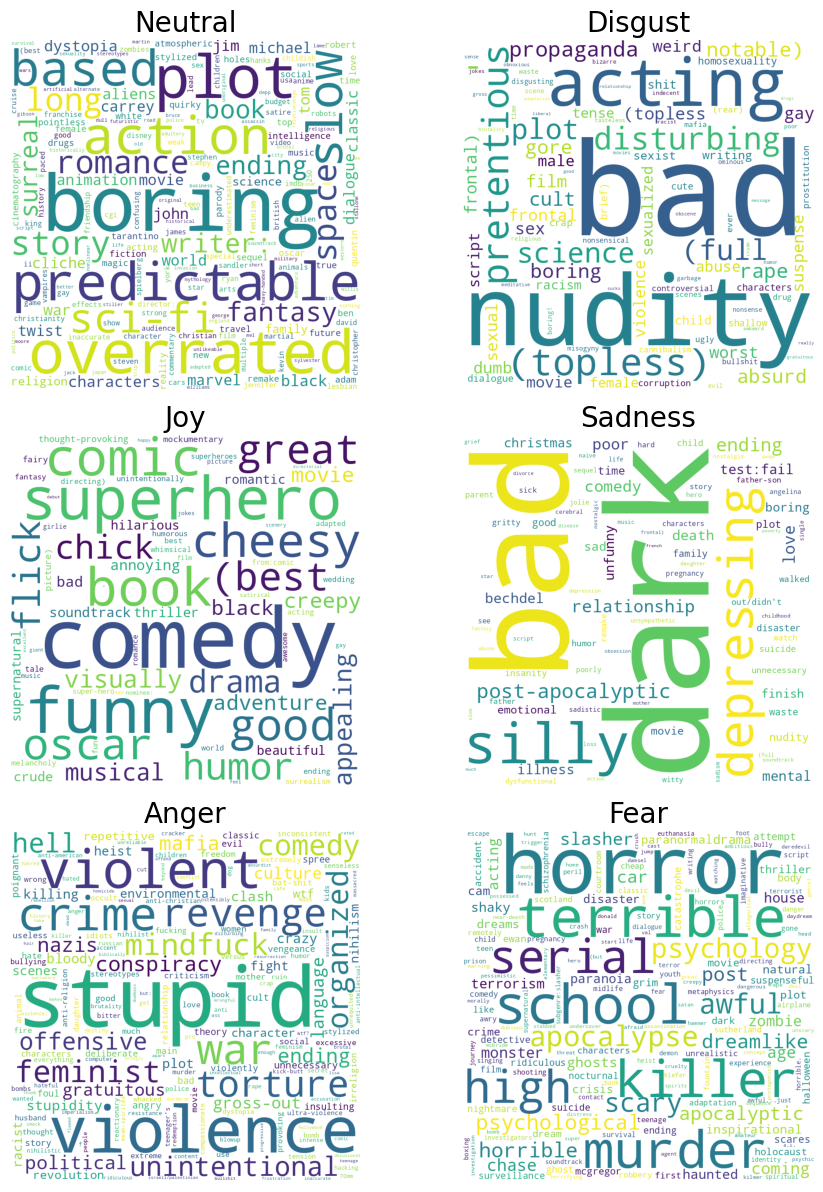

In [19]:
compute_wordclouds(df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 2)])

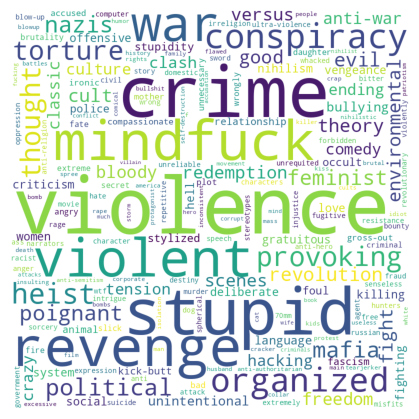

In [20]:
# from wordcloud import get_wordcloud, compute_wordclouds
wordcloud = get_wordcloud(
    df.loc[(df["num_rating"] > 50) & (abs(df["avg_rating"] - df["rating"]) >= 0.8) & (df["emotion"] == "anger")]
)

plt.figure(figsize=(4,4), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

38669


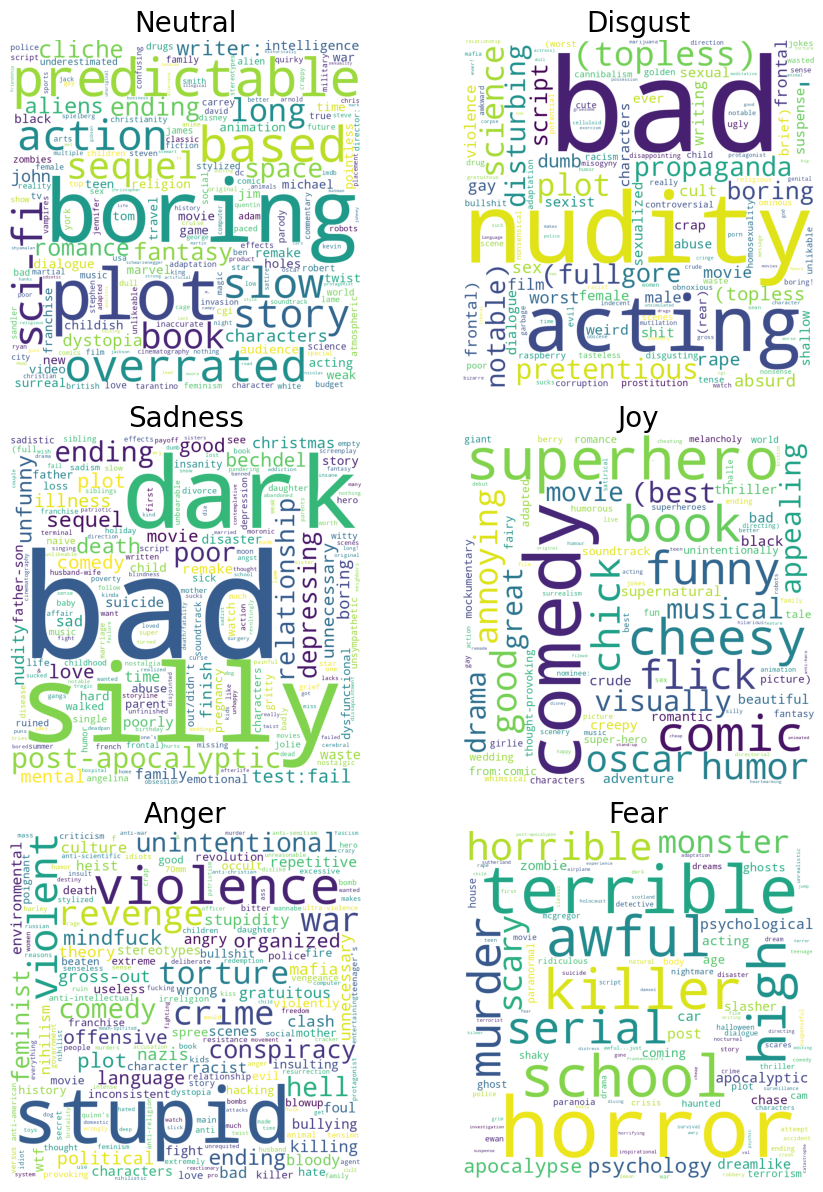

In [90]:
compute_wordclouds(df.loc[(df["num_rating"] > 50) & ((df["rating"]) < 2)])

In [95]:
three_word_neutral_tags = len(df.loc[(df.name.str.contains(r"\ .*\ ")) & (df["emotion"] == "neutral")]) / len(df.loc[df["emotion"] == "neutral"])
two_word_neutral_tags = len(df.loc[(df.name.str.contains(r"\ ")) & (df["emotion"] == "neutral")]) / len(df.loc[df["emotion"] == "neutral"])
print(f"Count of neutral tags that contained at at least two words: {two_word_neutral_tags}")
print(f"Count of neutral tags that contained at at least three words: {three_word_neutral_tags}")

Count of neutral tags that contained at at least two words: 0.46007246553702263
Count of neutral tags that contained at at least three words: 0.07778362864725186


In [ ]:
three_word_neutral_tags = len(df.loc[(df.name.str.contains(r"\ .*\ ")) & (df["emotion"] == "joy")]) / len(df.loc[df["emotion"] == "joy"])
two_word_neutral_tags = len(df.loc[(df.name.str.contains(r"\ ")) & (df["emotion"] == "joy")]) / len(df.loc[df["emotion"] == "joy"])
print(f"Count of neutral tags that contained at at least two words: {two_word_neutral_tags}")
print(f"Count of neutral tags that contained at at least three words: {three_word_neutral_tags}")

In [99]:
len(df.loc[(~df.name.str.contains(r"\ "))]) / len(df)

0.548352061187826

In [100]:
len(df.loc[(~df.name.str.contains(r"\ .+\ "))]) / len(df)

0.9150407228486247

In [51]:
df.loc[df["user_id"] == 11109].drop_duplicates(subset="name").sample(50)

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating,clean_name
40481,11109,6396,Francis Ford Coppola,0.832225,neutral,2016-12-25 09:57:09,0.5,2016-12-25 09:57:02,2.815385,130,francis ford coppola
41625,11109,135133,Writer: Suzanne Collins,0.855665,neutral,2016-11-10 04:47:27,0.5,2016-11-10 04:47:08,3.421994,3801,writer: suzanne collins
40598,11109,32587,Rutger Hauer,0.606195,neutral,2016-07-21 22:58:16,4.0,2015-01-17 05:17:03,3.787955,23594,rutger hauer
40200,11109,897,author:Ernest Hemingway,0.768251,neutral,2016-07-06 23:26:59,2.5,2016-07-06 23:26:40,3.646561,945,author:ernest hemingway
41243,11109,115713,cybernetics,0.795432,neutral,2016-05-04 01:46:24,3.0,2016-05-04 01:45:17,3.955001,11667,cybernetics
40855,11109,92923,lack of character depth,0.446844,neutral,2016-04-20 13:29:02,1.5,2016-04-20 13:29:29,2.434211,38,lack character depth
40834,11109,77307,seclusion,0.542412,sadness,2017-01-13 04:52:09,2.5,2017-01-13 04:50:56,3.733232,984,seclusion
41235,11109,115713,Androids and Robots,0.896658,neutral,2016-05-04 01:50:59,3.0,2016-05-04 01:45:17,3.955001,11667,androids robots
41784,11109,148369,fjord,0.622869,neutral,2016-12-15 08:32:31,4.0,2016-12-15 08:31:29,3.349206,126,fjord
41773,11109,147471,terrible music,0.964538,fear,2016-06-08 15:46:01,3.5,2016-06-08 15:45:47,3.500000,12,terrible music


In [40]:
df.loc[df["user_id"] == 19007]["rating"].mean()

2.724390551976759

In [57]:
df["days_delta"] = abs((df["tag_date_time"] - df["rating_date_time"]).dt.days)

In [93]:
df.loc[df["days_delta"] > 1000]

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating,clean_name,days_delta,title,genres
270,157,318,story line,0.700597,neutral,2011-06-03 23:26:50,5.0,2006-05-12 22:54:53,4.424188,97999,story line,1848,"Shawshank Redemption, The (1994)",Crime|Drama
1406,719,2329,Edward Norton,0.837200,neutral,2013-08-07 13:48:12,4.5,2009-11-17 08:17:12,4.140882,34110,edward norton,1359,American History X (1998),Crime|Drama
1407,719,2329,thought-provoking,0.749619,joy,2013-08-07 13:48:21,4.5,2009-11-17 08:17:12,4.140882,34110,thought-provoking,1359,American History X (1998),Crime|Drama
1417,719,4226,complicated,0.896936,neutral,2014-02-23 00:30:44,4.5,2008-09-20 02:31:52,4.153844,43739,complicated,1981,Memento (2000),Mystery|Thriller
1418,719,4226,dark,0.736945,sadness,2014-02-23 00:31:08,4.5,2008-09-20 02:31:52,4.153844,43739,dark,1981,Memento (2000),Mystery|Thriller
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830355,283195,351,jazz,0.372096,neutral,2011-10-18 13:00:02,5.0,2002-05-19 14:05:45,3.304437,3899,jazz,3438,"Corrina, Corrina (1994)",Comedy|Drama|Romance
830356,283195,538,thought provoking,0.554335,anger,2009-05-24 19:53:11,5.0,2002-05-19 13:59:33,3.693968,5421,thought provoking,2562,Six Degrees of Separation (1993),Drama
830357,283195,38038,parody,0.857073,neutral,2009-05-24 19:52:00,5.0,2005-10-16 16:08:32,3.701942,6128,parody,1316,Wallace & Gromit in The Curse of the Were-Rabb...,Adventure|Animation|Children|Comedy
830358,283195,38038,quirky,0.497387,neutral,2009-05-24 19:51:58,5.0,2005-10-16 16:08:32,3.701942,6128,quirky,1316,Wallace & Gromit in The Curse of the Were-Rabb...,Adventure|Animation|Children|Comedy


In [65]:
# Retrieve the average rating for each movie and the count of how many ratings a movie has received
GET_MOVIES = "SELECT * FROM Movie;"

df_movies = pd.read_sql(GET_MOVIES, get_db_connection())
df_movies.sample(5)

/tmp/ipykernel_3226328/2293875689.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_movies = pd.read_sql(GET_MOVIES, get_db_connection())


,id,title,genres
8196,8879,Murder on the Orient Express (1974),Crime|Mystery|Thriller
57464,192247,Banshee Blacktop (2016),Drama|Horror
53541,183239,Singam II (2013),Action|Comedy|Crime|Thriller
56035,188595,Bubblegum,(no genres listed)
32875,136277,Io so che tu sai che io so (1982),(no genres listed)


In [74]:
df_movies.rename(columns={"id": "movie_id"}, inplace=True)

In [69]:
def get_all_genres(genres: list[str]) -> list[str]:
    """
    Given a list of strings containing genre's, 
    """
    all_genres = set()
    for entry in genres:
        if isinstance(entry, str):
            all_genres.update(entry.split("|"))
    
    return list(all_genres)

all_genres = get_all_genres(df_movies["genres"].tolist())

In [76]:
df = pd.merge(df, df_movies, on="movie_id", how="left")
df.head()

/tmp/ipykernel_3226328/2142831799.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  averages.append(df.loc[df.genres.str.contains(all_genres[i])].rating.mean())


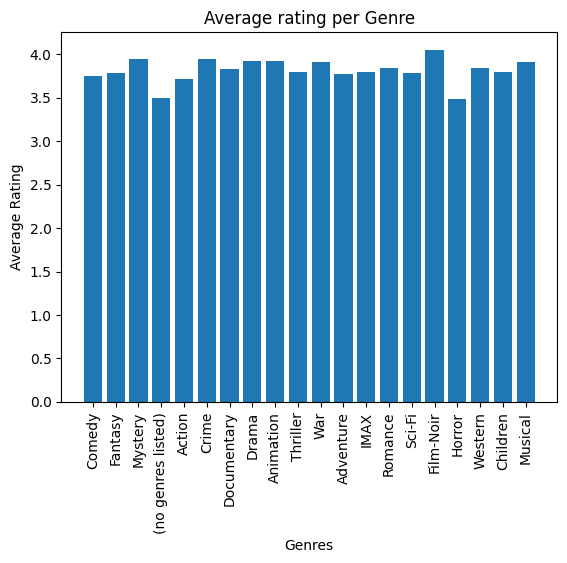

In [152]:
averages = []
for i in range(len(all_genres)):
    averages.append(df.loc[df.genres.str.contains(all_genres[i])].rating.mean())

plt.bar(all_genres, averages)
plt.xlabel("Genres")
plt.ylabel("Average Rating")
plt.title("Average rating per Genre")
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_3226328/535403059.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  stds.append(df.loc[df.genres.str.contains(all_genres[i])].rating.std())


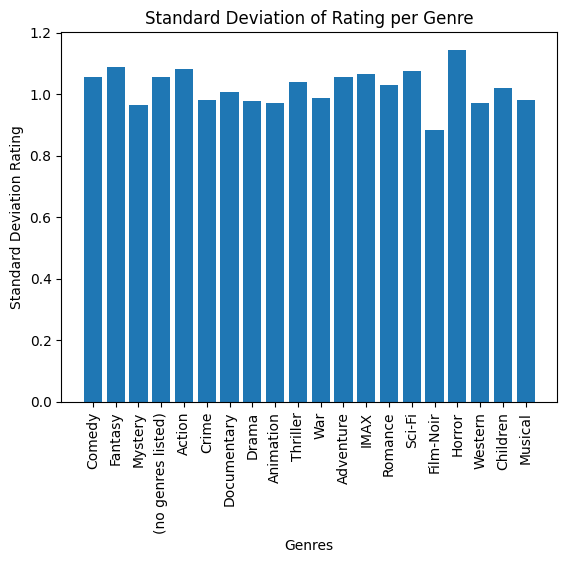

In [151]:
stds = []
for i in range(len(all_genres)):
    stds.append(df.loc[df.genres.str.contains(all_genres[i])].rating.std())

plt.bar(all_genres, stds)
plt.xlabel("Genres")
plt.ylabel("Standard Deviation Rating")
plt.title("Standard Deviation of Rating per Genre")
plt.xticks(rotation=90)
plt.show()

In [182]:
index = list(df.emotion.unique())
columns = {genre: [0 for i in range(len(index))] for genre in all_genres}
dx = pd.DataFrame(data=columns, index=index)
dx.head()

,Comedy,Fantasy,Mystery,(no genres listed),Action,Crime,Documentary,Drama,Animation,Thriller,War,Adventure,IMAX,Romance,Sci-Fi,Film-Noir,Horror,Western,Children,Musical
surprise,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
neutral,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
fear,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
anger,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
disgust,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [162]:
for genre in all_genres:
    emotions = df[["emotion", "rating", "genres"]].loc[df["genres"].str.contains(genre)].groupby("emotion").mean(numeric_only=True).to_dict()["rating"]
    for emotion, score in emotions.items():
        dx.loc[dx.index == emotion, genre] = score

dx.head()

/tmp/ipykernel_3226328/1565934963.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  emotions = df[["emotion", "rating", "genres"]].loc[df["genres"].str.contains(genre)].groupby("emotion").mean(numeric_only=True).to_dict()["rating"]


,Comedy,Fantasy,Mystery,(no genres listed),Action,Crime,Documentary,Drama,Animation,Thriller,War,Adventure,IMAX,Romance,Sci-Fi,Film-Noir,Horror,Western,Children,Musical
surprise,3.538397,3.774640,3.919942,3.517857,3.608733,3.747228,3.862369,3.836677,3.878927,3.635628,3.888013,3.763720,3.712462,3.719733,3.633400,4.017730,3.348584,3.814371,3.672165,3.928152
neutral,3.737400,3.782890,3.944015,3.490481,3.729473,3.935959,3.853857,3.910859,3.901286,3.801737,3.899306,3.774216,3.799091,3.837024,3.806665,4.042519,3.484357,3.823874,3.773751,3.904549
fear,3.769616,3.871033,3.962698,3.707692,3.731601,3.990776,3.860520,4.013706,4.114769,3.809920,4.078380,3.775399,3.952955,3.984063,3.822336,4.073041,3.557303,3.774194,3.895009,3.905714
anger,3.511014,3.641539,3.950145,3.467742,3.672863,3.920646,3.722299,3.886532,3.784647,3.788030,3.871412,3.597295,3.859303,3.613778,3.667519,4.066937,3.287111,3.789242,3.548580,3.748804
disgust,3.472726,3.308803,3.743564,3.087786,3.284469,3.790677,3.515720,3.697083,3.684633,3.591355,3.637871,3.295949,3.223069,3.537643,3.339361,3.942464,3.380049,3.689826,3.589691,3.675439


<AxesSubplot: title={'center': 'Average Rating vs Genre'}>

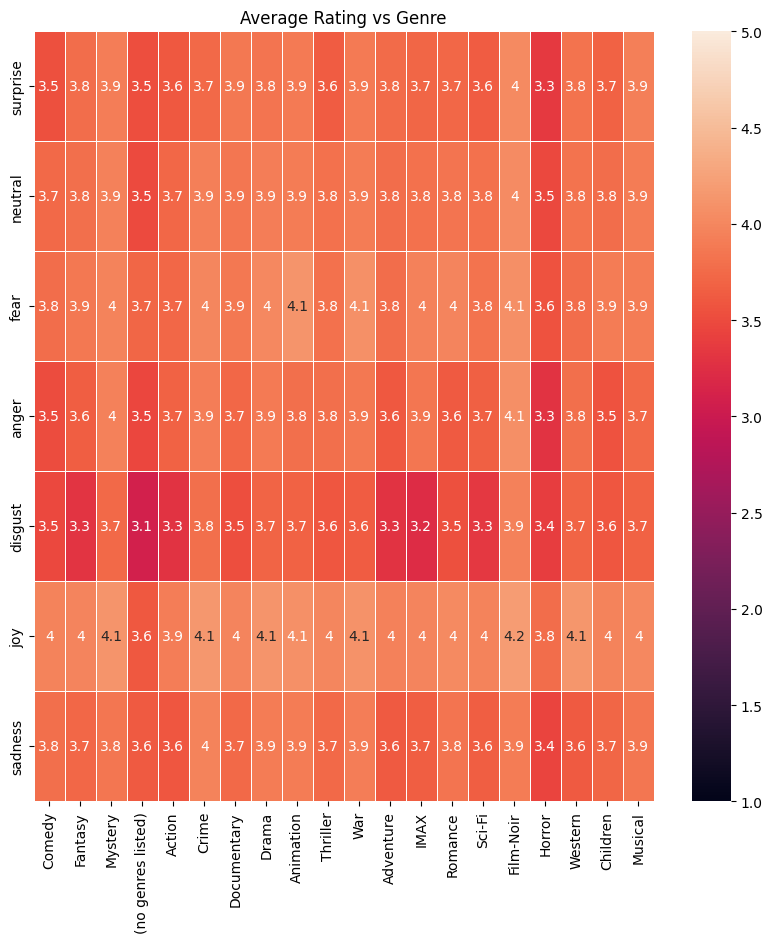

In [179]:
plt.subplots(figsize=(10,10))
plt.title("Average Rating vs Genre")
sns.heatmap(dx, annot=True, linewidths=0.5, vmax=5, vmin=1)

/tmp/ipykernel_3226328/3383189968.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.plot(df[["rating_date_time", "rating"]].groupby(df["rating_date_time"].dt.date).mean())


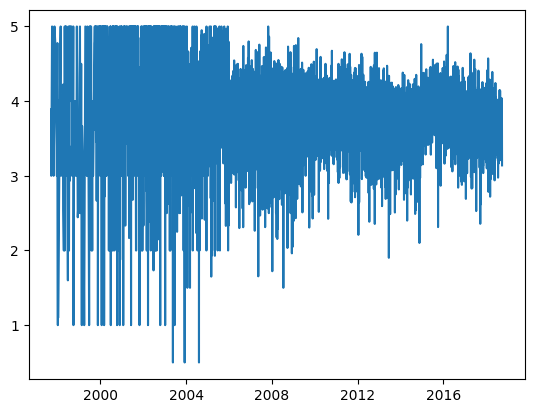

In [107]:
plt.plot(df[["rating_date_time", "rating"]].groupby(df["rating_date_time"].dt.date).mean())
plt.show()

In [108]:
df[["rating_date_time", "rating"]].groupby(df["rating_date_time"].dt.date).mean().head()

/tmp/ipykernel_3226328/682306189.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df[["rating_date_time", "rating"]].groupby(df["rating_date_time"].dt.date).mean().head()


,rating
rating_date_time,
1997-09-15,3.888889
1997-09-17,3.000000
1997-10-01,5.000000
1997-10-14,4.500000
1997-10-16,4.333333


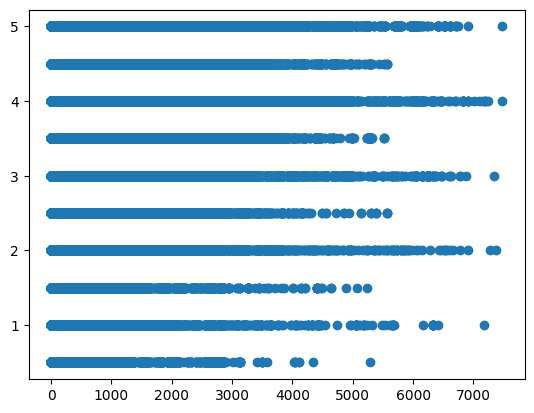

In [63]:
plt.scatter(df["days_delta"], df["rating"])
plt.show()

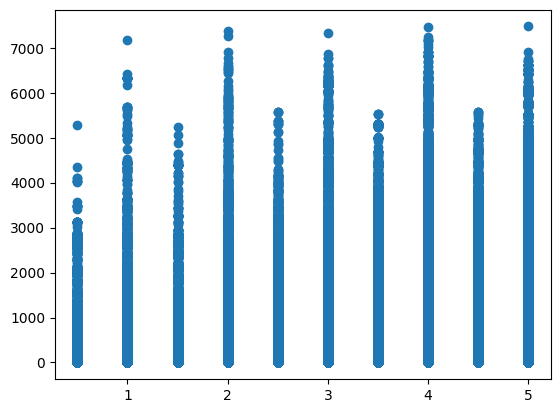

In [95]:
plt.scatter(df["rating"], df["days_delta"])
plt.show()

In [132]:
df.loc[df.genres == "Horror"].drop_duplicates(subset=["title"])

,user_id,movie_id,name,score,emotion,tag_date_time,rating,rating_date_time,avg_rating,num_rating,clean_name,days_delta,title,genres
512,449,1984,All Hallows' Eve,0.343417,neutral,2017-10-10 20:12:14,3.5,2017-10-10 20:09:58,1.992713,1235,hallows' eve,0,Halloween III: Season of the Witch (1982),Horror
568,449,2517,boring,0.683058,neutral,2017-10-01 14:07:03,1.5,2017-10-01 13:56:55,3.076645,2629,boring,0,Christine (1983),Horror
837,449,110591,horror,0.981672,fear,2017-04-02 18:09:08,4.5,2017-03-18 12:51:41,3.410714,812,horror,15,Oculus (2013),Horror
860,449,113771,extra blurry action scenes,0.383763,neutral,2017-10-22 16:31:36,0.5,2017-10-22 16:31:27,2.692308,39,extra blurry action scenes,0,Exists (2014),Horror
866,449,115534,ghosts,0.452176,fear,2017-10-14 12:13:29,1.0,2017-10-14 12:11:24,2.364000,250,ghosts,0,Ouija (2014),Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807363,275402,184599,found footage,0.441137,neutral,2018-06-19 07:47:44,1.5,2018-06-19 08:16:47,3.000000,4,found footage,1,The Houses October Built 2 (2017),Horror
807435,275402,190513,ghost,0.658733,fear,2018-07-03 11:40:49,3.0,2018-07-03 11:40:34,3.000000,1,ghost,0,Ju-Rei: The Uncanny (2004),Horror
813306,276256,110451,Badly written,0.661058,disgust,2014-04-11 14:37:19,2.0,2014-04-26 13:26:07,2.596774,93,badly written,15,"Quiet Ones, The (2014)",Horror
816960,277730,120921,psychology,0.393603,fear,2015-01-07 07:51:55,3.0,2015-01-05 07:49:47,2.100000,5,psychology,2,Miss Zombie (2013),Horror
